# Training EDA : Analyze the frequentation of the SNCF Station during from 2019 and 2025

Guillaume EGU

## Overview 

This project focuses on an Exploratory Data Analysis (EDA) and a baseline predictive modeling task using passenger count data from the Transilien train network (SNCF). <br>
The dataset contains daily records of passenger traffic across different stations, lines, and time slots.
The goal is to reveals clear temporal patterns and understand this dataset the more I can.

## Contents

<ul style ="padding-left: 75px;"> 
    <li>Import Libraries </li>
    <li>Functions </li>
    <li>Data Loading & Overview </li>
    <li>Data Exploration </li>
    <li>Feature Engineering </li>
    <li>Prepare data for modelling</li>
</ul>
</p>

<hr>

### Import Libraries

<hr>

In [39]:
import pandas as pd
import plotly.express as px
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

<hr>

### Functions

<hr>

In [ ]:
def rename_col(df: pd.DataFrame):
    df=df.copy()

    df.columns = (
        df.columns
        .str.replace('\ufeff', '', regex=False)
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
    )
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df

def parse_tranche_horaire_to_hours(s: str):
    """
    Converts a textual time slot into approximate (start_hour, end_hour) values.
    Expected examples from the dataset:
    "Avant 6h" → (0, 6)
    "De 6h à 10h" → (6, 10)
    "De 10h à 16h" → (10, 16)
    "De 16h à 20h" → (16, 20)
    "Après 20h" → (20, 24)
    """
    if not isinstance(s, str) or not s:
        return (np.nan, np.nan)
    s = s.lower().strip()
    if 'avant' in s and '6' in s:
        return (0, 6)
    if 'après' in s or 'apres' in s:
        num = ''.join(ch for ch in s if ch.isdigit())
        h = int(num) if num else 20
        return (h, 24)
    if 'de' in s and 'à' in s:
        parts = s.replace('à', 'a').split()
        nums = [int(''.join(ch for ch in p if ch.isdigit())) for p in parts if any(ch.isdigit() for ch in p)]
        if len(nums) == 2:
            return (nums[0], nums[1])
    return (np.nan, np.nan)


def daily_station_aggregate(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates data by (date, station_name, line) to prepare for temporal analyses and potential regression models (daily traffic).
    """
    grp_cols = [c for c in ['date', 'nom_gare', 'ligne'] if c in df.columns]
    out = (df
           .groupby(grp_cols, dropna=False)['somme_de_montants']
           .sum()
           .reset_index()
           .rename(columns={'somme_de_montants': 'trafic_journalier'}))
    return out

<hr>

### Data loading & Overview

Load, clean, and prepare the raw dataset.

<hr>

In [23]:
# Reading the data & take a look on the first rows
df = pd.read_csv("comptage-voyageurs-trains-transilien.csv", sep=';')
df = rename_col(df)
df.head()


,nom_gare,code_gare,type_jour,date,annee,ligne,axe,tranche_horaire,somme_de_montants
0,ACHERES-VILLE,87381657,DIM,2022-11-20,2022,A,A,Avant 6h,39
1,BEYNES,87393363,SAM,2024-01-20,2024,N,N,De 10h à 16h,94
2,CHAMP-DE-COURSES-D'ENGHIEN,87276030,DIM,2024-01-21,2024,H,H,De 10h à 16h,727
3,CHAMP-DE-COURSES-D'ENGHIEN,87276030,SAM,2024-01-20,2024,H,H,Avant 6h,47
4,CHAMP-DE-MARS-TOUR-EIFFEL,87393058,DIM,2025-09-02,2025,C,C,Avant 6h,8


In [24]:
# Getting columns and types to see what pre-processing things I have to do
print("Dimensions :", df.shape)
print(df.info())

Dimensions : (7328, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7328 entries, 0 to 7327
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   nom_gare           7328 non-null   object        
 1   code_gare          7328 non-null   int64         
 2   type_jour          7328 non-null   object        
 3   date               7328 non-null   datetime64[ns]
 4   annee              7328 non-null   int64         
 5   ligne              7328 non-null   object        
 6   axe                7328 non-null   object        
 7   tranche_horaire    7328 non-null   object        
 8   somme_de_montants  7328 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 515.4+ KB
None


In [25]:
#Let's analyse the object columns 
df_objects_columns = df.select_dtypes(include=['object'])
print(df_objects_columns.dtypes)

print(df_objects_columns['nom_gare'].apply(type).unique())
print(df_objects_columns['type_jour'].apply(type).unique())
print(df_objects_columns['ligne'].apply(type).unique())
print(df_objects_columns['axe'].apply(type).unique())
print(df_objects_columns['tranche_horaire'].apply(type).unique())

nom_gare           object
type_jour          object
ligne              object
axe                object
tranche_horaire    object
dtype: object
[<class 'str'>]
[<class 'str'>]
[<class 'str'>]
[<class 'str'>]
[<class 'str'>]


In [26]:
#Let's check unique value to detect any error in the dataset
#Class, Number = np.unique(df['nom_gare'], return_counts=True)
Class, Number = np.unique(df['type_jour'], return_counts=True)
#Class, Number = np.unique(df['ligne'], return_counts=True)
#Class, Number = np.unique(df['axe'], return_counts=True)
#Class, Number = np.unique(df['tranche_horaire'], return_counts=True)
print(Class, Number)

['DIM' 'JOB' 'SAM'] [2393 2502 2433]


In [ ]:
#It's seems there is no errors in the datasets
#Let's now check the overall statistics
df.describe(include="all")

,nom_gare,code_gare,type_jour,date,annee,ligne,axe,tranche_horaire,somme_de_montants
count,7328,7.328000e+03,7328,7328,7328.000000,7328,7328,7328,7328.000000
unique,434,NaN,3,NaN,NaN,17,21,5,NaN
top,PARIS-SAINT-LAZARE,NaN,JOB,NaN,NaN,C,C,Après 20h,NaN
freq,74,NaN,2502,NaN,NaN,1223,1118,1524,NaN
mean,NaN,8.740263e+07,NaN,2023-12-16 20:05:34.061135360,2023.620087,NaN,NaN,NaN,893.398062
min,NaN,8.700148e+07,NaN,2019-03-16 00:00:00,2019.000000,NaN,NaN,NaN,0.000000
25%,NaN,8.727611e+07,NaN,2023-11-19 00:00:00,2023.000000,NaN,NaN,NaN,40.000000
50%,NaN,8.738237e+07,NaN,2024-01-20 00:00:00,2024.000000,NaN,NaN,NaN,181.000000
75%,NaN,8.754524e+07,NaN,2024-04-23 00:00:00,2024.000000,NaN,NaN,NaN,702.000000
max,NaN,8.798872e+07,NaN,2025-11-02 00:00:00,2025.000000,NaN,NaN,NaN,47213.000000


In [28]:
#Let's check missing values
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame("missing_ratio").head(20))

,missing_ratio
nom_gare,0.0
code_gare,0.0
type_jour,0.0
date,0.0
annee,0.0
ligne,0.0
axe,0.0
tranche_horaire,0.0
somme_de_montants,0.0


In [ ]:
#No Missing Values

<hr>

### Data Exploration

Explore traffic distributions by station, line, day of week, and time slot.

Identify the most frequented stations and analyze temporal trends (e.g., weekday vs. weekend, annual patterns).

<hr>

In [ ]:
"""
   Add derived temporal features from date and time slot.
"""
df = df.copy()
if 'date' in df.columns:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday  # 0=lundi
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

if 'tranche_horaire' in df.columns:
    hours = df['tranche_horaire'].apply(parse_tranche_horaire_to_hours)
    df['start_hour'] = hours.apply(lambda x: x[0])
    df['end_hour'] = hours.apply(lambda x: x[1])
    df['hour_bucket'] = (df['start_hour'] + df['end_hour']) / 2.0
print(df.head())

                     nom_gare  code_gare type_jour       date  annee ligne  \
0               ACHERES-VILLE   87381657       DIM 2022-11-20   2022     A   
1                      BEYNES   87393363       SAM 2024-01-20   2024     N   
2  CHAMP-DE-COURSES-D'ENGHIEN   87276030       DIM 2024-01-21   2024     H   
3  CHAMP-DE-COURSES-D'ENGHIEN   87276030       SAM 2024-01-20   2024     H   
4   CHAMP-DE-MARS-TOUR-EIFFEL   87393058       DIM 2025-09-02   2025     C   

  axe tranche_horaire  somme_de_montants  year  month  day  weekday  \
0   A        Avant 6h                 39  2022     11   20        6   
1   N    De 10h à 16h                 94  2024      1   20        5   
2   H    De 10h à 16h                727  2024      1   21        6   
3   H        Avant 6h                 47  2024      1   20        5   
4   C        Avant 6h                  8  2025      9    2        1   

   is_weekend  start_hour  end_hour  hour_bucket  
0           1           0         6          3.0  
1 

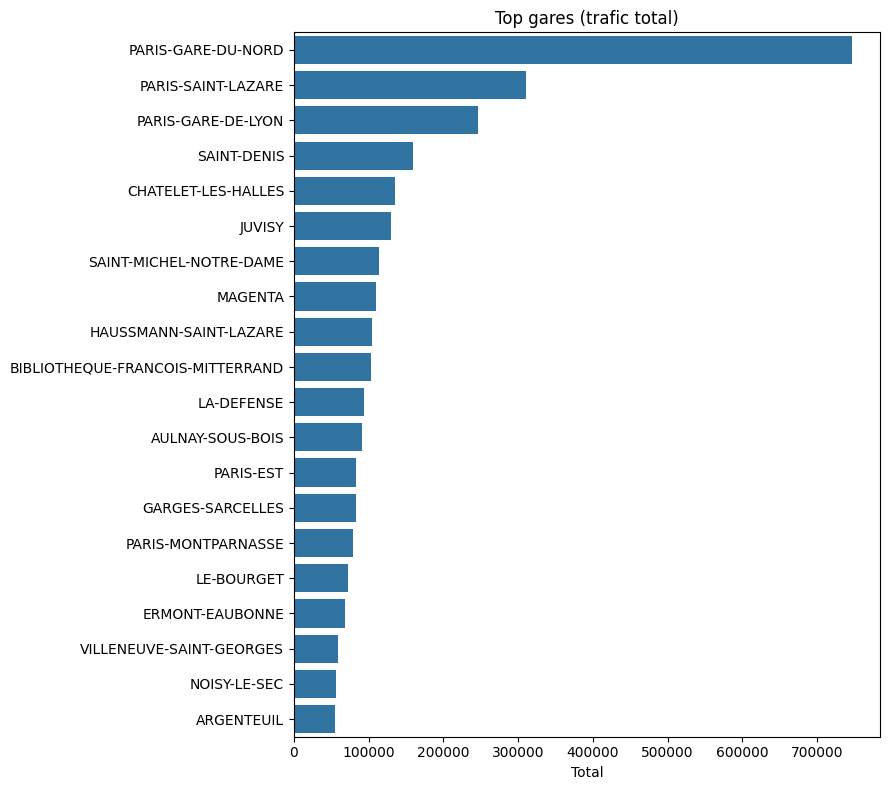

In [ ]:
# Top gares (total)
if 'nom_gare' in df.columns:
    top_gares = df.groupby('nom_gare')['somme_de_montants'].sum()
    s = top_gares.sort_values(ascending=False).head(20)
    plt.figure(figsize=(9, min(0.4*len(s), 10)))
    sns.barplot(x=s.values, y=s.index)
    plt.title("Top gares (total traffic)")
    plt.xlabel('Total')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [ ]:
# Traffic by line
if 'ligne' in df.columns:
    trafic_lignes = df.groupby('ligne')['somme_de_montants'].sum().sort_values(ascending=False)
    fig = px.bar(trafic_lignes, title="Total traffic by line")
    fig.update_layout(xaxis_title='Line', yaxis_title='Total traffic')
    fig.show()

In [41]:
# Distribution by time slot (ordered approximately by midpoint hour)
if 'tranche_horaire' in df.columns:
    ordre = (df[['tranche_horaire','hour_bucket']]
             .drop_duplicates()
             .sort_values('hour_bucket'))['tranche_horaire'].tolist()
    trafic_tranches = (df
        .groupby('tranche_horaire')['somme_de_montants']
        .sum()
        .reindex(ordre))
    fig = px.bar(trafic_tranches, title="Total traffic by time slot")
    fig.update_layout(xaxis_title='Time slot', yaxis_title='Total traffic')
    fig.show()

In [42]:
# weekend vs weekday traffic
if 'is_weekend' in df.columns:
    agg = df.groupby('is_weekend')['somme_de_montants'].sum()
    labels = ['Semaine (0)', 'Weekend (1)']
    fig = px.pie(values=agg.values, names=[labels[i] for i in agg.index], title="Trafic share: Weekday vs Weekend")
    fig.show()

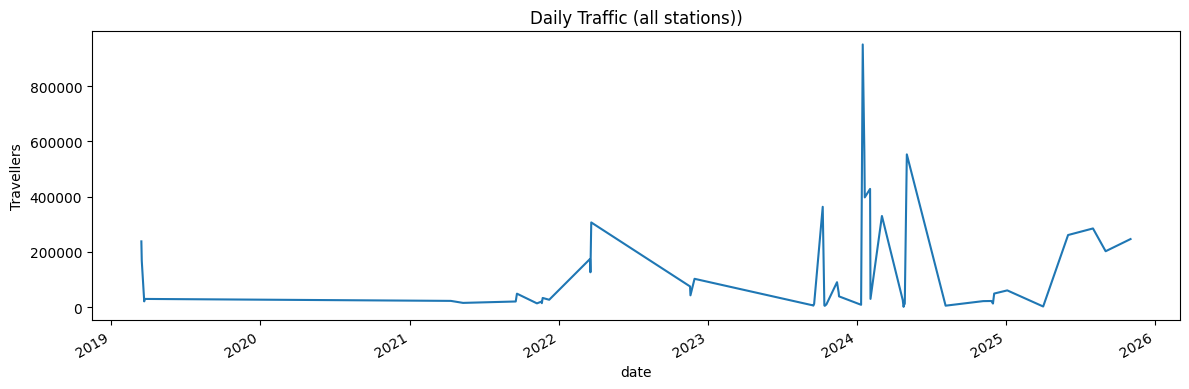

In [43]:
# Global daily traffic
daily = df.groupby('date')['somme_de_montants'].sum().sort_index()
plt.figure(figsize=(12,4))
daily.plot()
plt.title("Daily Traffic (all stations))")
plt.ylabel("Travellers")
plt.tight_layout()
plt.show()

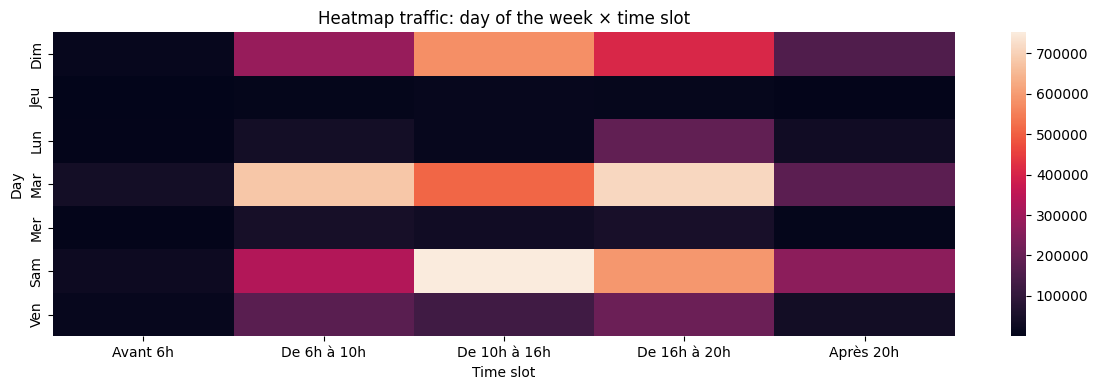

In [ ]:
# Heatmap jour_de_semaine (day of the week) x somme_tranche_horaire (addition of time slots)
if {'weekday','tranche_horaire','somme_de_montants'}.issubset(df.columns):
    pivot = (df
             .groupby(['weekday','tranche_horaire'])['somme_de_montants']
             .sum()
             .reset_index())
    # ordonate columns
    pivot['weekday_name'] = pivot['weekday'].map({0:'Lun/Mon',1:'Mar/Tue',2:'Mer/Wes',3:'Jeu/Thu',4:'Ven/Fri',5:'Sam/Satu',6:'Dim/Sun'})
    pivot = pivot.merge(
        df[['tranche_horaire','hour_bucket']].drop_duplicates(),
        on='tranche_horaire', how='left'
    )
    heat = pivot.pivot_table(index='weekday_name', columns='tranche_horaire', values='somme_de_montants', aggfunc='sum')
    # reordonate rows by hour_bucket
    ordre_tranches = (
        df[['tranche_horaire','hour_bucket']]
        .drop_duplicates()
        .sort_values('hour_bucket')['tranche_horaire']
        .tolist()
    )
    heat = heat[ordre_tranches]
    plt.figure(figsize=(12,4))
    sns.heatmap(heat, annot=False)
    plt.title("Heatmap traffic: day of the week × time slot")
    plt.xlabel("Time slot")
    plt.ylabel("Day")
    plt.tight_layout()
    plt.show()

<hr>

### Feature Engineering 

Objective: build a clean training dataset (e.g., daily traffic per station) enriched with derived features such as day, month, weekend indicator, encoded line, and simple lag/rolling statistics.

<hr>

In [ ]:
# Aggregated table: daily traffic by (station, line)
df_day = daily_station_aggregate(df)

# Adding temporal features from date
df_day['year']    = df_day['date'].dt.year
df_day['month']   = df_day['date'].dt.month
df_day['day']     = df_day['date'].dt.day
df_day['weekday'] = df_day['date'].dt.weekday
df_day['is_weekend'] = df_day['weekday'].isin([5,6]).astype(int)

# Lags / moving averages (by station)
df_day = df_day.sort_values(['nom_gare', 'date'])
for lag in [1,7]:
    df_day[f'lag_{lag}'] = df_day.groupby('nom_gare')['trafic_journalier'].shift(lag)

df_day['roll7_mean'] = (df_day
                        .groupby('nom_gare')['trafic_journalier']
                        .transform(lambda x: x.shift(1).rolling(7, min_periods=3).mean()))

# Drop of the very first rows without lags
df_model = df_day.dropna(subset=['lag_1','lag_7','roll7_mean']).reset_index(drop=True)

print("Table d'apprentissage:", df_model.shape)
display(df_model.head())

Table d'apprentissage: (55, 12)


,date,nom_gare,ligne,trafic_journalier,year,month,day,weekday,is_weekend,lag_1,lag_7,roll7_mean
0,2023-10-10,AULNAY-SOUS-BOIS,B,35819,2023,10,10,1,0,4326.0,20023.0,7260.571429
1,2024-01-16,AULNAY-SOUS-BOIS,K,3778,2024,1,16,1,0,35819.0,7902.0,9517.142857
2,2024-01-20,AULNAY-SOUS-BOIS,K,738,2024,1,20,5,1,3778.0,5725.0,8928.000000
3,2024-01-21,AULNAY-SOUS-BOIS,K,225,2024,1,21,6,1,738.0,2256.0,8215.571429
4,2024-08-06,CHAVILLE-RIVE-DROITE,U,101,2024,8,6,1,0,370.0,3126.0,1152.571429


<hr>

### Prepare Data for Modelling

Here we prepare an X/y dataset for a regression task (e.g., predicting the daily traffic of a station on day J using temporal features, lags, and line information). We keep it simple and modular.

<hr>

In [ ]:
target = 'trafic_journalier'
numeric_features = ['year','month','day','weekday','is_weekend','lag_1','lag_7','roll7_mean']
categorical_features = []
if 'ligne' in df_model.columns:
    categorical_features.append('ligne')
if 'nom_gare' in df_model.columns:
    categorical_features.append('nom_gare')

X = df_model[numeric_features + categorical_features]
y = df_model[target]

# Preprocessing for model
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Simple baseline model
from sklearn.linear_model import Ridge
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('estimator', Ridge(alpha=1.0, random_state=42))
])

model.fit(X_train, y_train)
pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
r2  = r2_score(y_test, pred)
print(f"Baseline – MAE: {mae:,.2f} | R²: {r2:,.3f}")


Baseline – MAE: 9,451.77 | R²: 0.313


MAE (Mean Absolute Error) ≈ 9,452 passengers
→ On average, the model is off by about 9,500 passengers per observation (station × day in your case).
→ If a station typically has around 50,000 passengers/day, an error of 9,500 represents roughly a 20% deviation.

R² (Coefficient of Determination) = 0.313
→ The model explains about 31% of the total variance in traffic.
→ In other words, it captures part of the structure, but there is still a large amount of unexplained variability.

This result suggests that passenger traffic is influenced by additional factors not included in the current dataset (e.g., weather, holidays, special events). While more advanced models could be tested to improve performance, exploring those is beyond the scope of today’s exercise.
